In [54]:
%load_ext autoreload
%autoreload 2


import os

import sys
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import jax
import jax.numpy as jnp
from jax import grad
from numpy.random import default_rng
from functools import partial
import time
import pandas as pd
from itertools import combinations
import itertools
from jax.scipy.special import factorial
import numpy as np
#from scipy.special import factorial

from thewalrus import perm

from p_pack import globals, pre_p, circ, model, loss, optimiser, train




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Example usage
out_state_combos = jnp.array(list(itertools.product(range(10), repeat=3)))
print('Output state combinations:', out_state_combos[:20])

def extract_submatrices(unitary):
    # unitary: (num_modes, 3)
    # out_state_combos: (n_combos, 3)
    return unitary[out_state_combos[:5], :] 

key = jax.random.PRNGKey(0)
random_matrix = jax.random.normal(key, (10, 3))
print('Random matrix:', random_matrix)

extracted_submatrices = extract_submatrices(random_matrix)
print('Extracted submatrices:', extracted_submatrices[:10])

# Count repeats for each combo
def count_repeats(combo):
    # Count occurrences of each value
    unique, counts = jnp.unique(combo, return_counts=True)
    # Only count repeats (counts > 1)
    repeats = counts[counts > 1]
    return repeats.sum() #- repeats.size  # subtract 1 for each unique repeated value

# Vectorize over all combos
repeats_per_combo = jnp.array([count_repeats(combo) for combo in out_state_combos])

print(repeats_per_combo[:20])

factorials = factorial(repeats_per_combo)

print('Factorials of repeats:', factorials[:20])

Output state combinations: [[0 0 0]
 [0 0 1]
 [0 0 2]
 [0 0 3]
 [0 0 4]
 [0 0 5]
 [0 0 6]
 [0 0 7]
 [0 0 8]
 [0 0 9]
 [0 1 0]
 [0 1 1]
 [0 1 2]
 [0 1 3]
 [0 1 4]
 [0 1 5]
 [0 1 6]
 [0 1 7]
 [0 1 8]
 [0 1 9]]
Random matrix: [[-0.28371066  0.9368162  -1.0050073 ]
 [ 1.4165013   1.0543301   0.9108127 ]
 [-0.42656708  0.986188   -0.5575324 ]
 [ 0.01532502 -2.078568    0.5548371 ]
 [ 0.91423655  0.5744596   0.7227863 ]
 [ 0.12106175 -0.3237354   1.6234998 ]
 [ 0.24500391 -1.3809781  -0.6111237 ]
 [ 0.1403725   0.84100425 -1.0943578 ]
 [-1.077502   -1.1396457  -0.593338  ]
 [-0.15576515 -0.38321444 -1.1144515 ]]
Extracted submatrices: [[[-0.28371066  0.9368162  -1.0050073 ]
  [-0.28371066  0.9368162  -1.0050073 ]
  [-0.28371066  0.9368162  -1.0050073 ]]

 [[-0.28371066  0.9368162  -1.0050073 ]
  [-0.28371066  0.9368162  -1.0050073 ]
  [ 1.4165013   1.0543301   0.9108127 ]]

 [[-0.28371066  0.9368162  -1.0050073 ]
  [-0.28371066  0.9368162  -1.0050073 ]
  [-0.42656708  0.986188   -0.5575324 ]

In [56]:


# Load MNIST data for handwritten digits '3' and '5'
# The dataset has 'x' rows, each representing an image
# Each row has 'y' columns: The first y-1 columns each correspond to a pixel feature, and the last column is the label
# A label of +1 represents the digit '3', and -1 represents the digit '5'

#file_path = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_5d_train.csv"
file_path = globals.get_mnist_csv_filepath("train")
data_train = pd.read_csv(file_path)
data_train = jnp.array(data_train)


#final column in the data is for labels 
num_features = data_train.shape[1] -1 

#file_path_1 = r"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_5d_test.csv"
file_path_1 = globals.get_mnist_csv_filepath("test")
data_test = pd.read_csv(file_path_1)
data_test = jnp.array(data_test)




# Spliiting the data into training and testing sets

train_set = data_train[:,:num_features]

# Rescale the training set to the range [-pi/2, pi/2]
train_set = pre_p.rescale_data(train_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

# The training labels are +1 for 3 and -1 for 5. 
train_labels = data_train[:,num_features]

# Not needed for now:
#train_labels_one_hot = jnp.zeros(shape = train_set.shape)
#train_labels_one_hot = train_labels_one_hot.at[tuple([jnp.arange(num_train),train_labels])].set(1)
test_set = data_test[:,:num_features]
# Rescale the test set to the range [-pi/2, pi/2]
test_set = pre_p.rescale_data(test_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

test_labels = data_test[:,num_features]

In [57]:
# Not needed for now:

print( train_set.shape, train_labels.shape, test_set.shape, test_labels.shape)

# Initialize the phases

# each feature has its own uploading BS so we had a factor of 2
init_phases = circ.initialize_phases(10, 2*num_features, )  

weights_data = jnp.ones(shape = [init_phases.shape[0],init_phases.shape[1]]) #weights for data reuploading
#print(init_phases)
#print(init_phases)

# If you didn't test any of the jitted functions yet, the ratio in times should be around a factor 10^3 - 10^5.
# The first time is larger because of the compilation.
# The second time is small because it just runs the compiled code.
# Also, try to get any of these run times in pure Python+Numpy.
b = time.time()
# The block_until_ready is supposed to only let Python continue when the compiled code has finished.
# For me, it's not reliable. Therefore, I print the results first before measuring the end time.
result1, result2, result3, x = jax.block_until_ready(model.full_unitaries_data_reupload)(init_phases, train_set, weights_data)
print(result1.shape)
print(result2.shape)
print(result3.shape)
e = time.time()
print(e-b)
b = time.time()
result1 , result2, result3, x  = jax.block_until_ready(model.full_unitaries_data_reupload)(init_phases, train_set, weights_data)
print(result1.shape)
print(result2.shape)
print(result3.shape)

e = time.time()
print(e-b)





(11551, 3) (11551,) (1901, 3) (1901,)
(11551, 6, 6)
(11551, 216, 3, 3)
(11551, 216)
3.063052177429199
(11551, 6, 6)
(11551, 216, 3, 3)
(11551, 216)
0.1852278709411621


Time 1.485660966237386 minutes
Loss on train set before training: 0.34741095
Loss on train set after training: 0.25614405
Loss on test set after training: 0.25329393


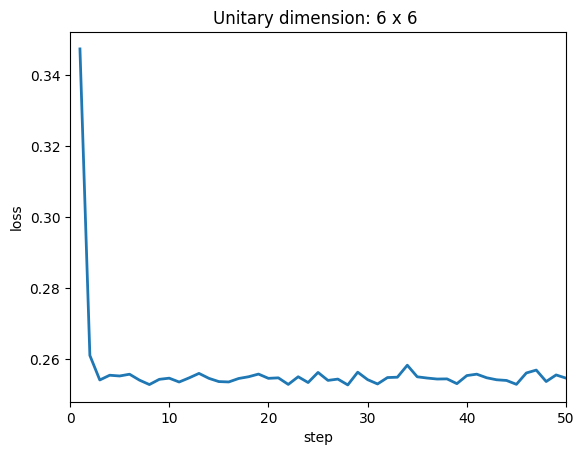

Total time: 1.4972567518552145 minutes


In [61]:
#Training the circuit

a = time.time()
step_size = 1e-2
# Initialize the carry for Adam.
init = (init_phases, train_set, train_labels, weights_data, 0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data)
# [params_phases, data_set, labels, params_weights, m_phases, v_phases, m_weights, v_weights]

# Run the training.
b = time.time()

carry, loss_mem = jax.block_until_ready(train.train(init))
trained_phases = carry[0]
trained_weights = carry[3]
#print(loss_mem[0])
#print(loss_mem[10])
#print(loss_mem[100])
#print(loss_mem[1000])
e = time.time()
print('Time', (e-b)/60, 'minutes')


temp_loss = loss.loss(init_phases, train_set, train_labels, weights_data)
print('Loss on train set before training:', temp_loss)

temp_loss = loss.loss(trained_phases, train_set, train_labels, trained_weights)
print('Loss on train set after training:', temp_loss)

temp_loss = loss.loss(trained_phases, test_set, test_labels, trained_weights)
# Let's test on our test data:
print('Loss on test set after training:', temp_loss)
 
fig, ax = plt.subplots()
ax.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), linewidth=2, label=r"learning curve" )
ax.set(xlim = (0,globals.num_steps), xlabel="step", ylabel = "loss",)
#ax.legend(fontsize=14)
unitary_shape = trained_phases.shape  
ax.set_title(f"Unitary dimension: {2*unitary_shape[1]} x {2*unitary_shape[1]} ")

plt.show()

d = time.time()
print('Total time:', (d-a)/60, 'minutes')


Training with depth = 4
Training with depth = 8
Training with depth = 16


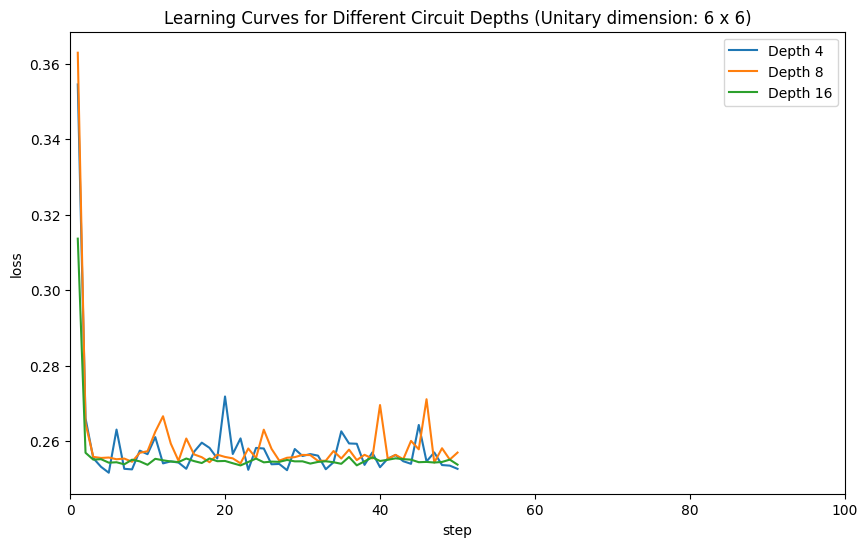

 depth  train_loss_before  train_loss_after  test_loss_after  train_time_min  total_time_min
     4             0.3545            0.2515           0.2510          0.1008          1.1508
     8             0.3629            0.2620           0.2643          0.1548          1.1590
    16             0.3137            0.2549           0.2541          0.3173          1.5707


In [65]:
#Varying the depth of the circuit

depth_list = [4, 8, 16]# 48, 56, 64]  # Example depths
num_steps = 100
step_size = 1e-2
# Load MNIST data for handwritten digits '3' and '5'
# The dataset has 'x' rows, each representing an image
# Each row has 'y' columns: The first y-1 columns each correspond to a pixel feature, and the last column is the label
# A label of +1 represents the digit '3', and -1 represents the digit '5'

file_path = globals.get_mnist_csv_filepath("train")
data_train = pd.read_csv(file_path)
data_train = jnp.array(data_train)


#final column in the data is for labels 
num_features = data_train.shape[1] -1 

file_path_1 = globals.get_mnist_csv_filepath("test")
data_test = pd.read_csv(file_path_1)
data_test = jnp.array(data_test)

num_steps = 100


# Spliiting the data into training and testing sets

train_set = data_train[:,:num_features]

# Rescale the training set to the range [-pi/2, pi/2]
train_set = pre_p.rescale_data(train_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

# The training labels are +1 for 3 and -1 for 5. 
train_labels = data_train[:,num_features]

# Not needed for now:
#train_labels_one_hot = jnp.zeros(shape = train_set.shape)
#train_labels_one_hot = train_labels_one_hot.at[tuple([jnp.arange(num_train),train_labels])].set(1)
test_set = data_test[:,:num_features]
# Rescale the test set to the range [-pi/2, pi/2]
test_set = pre_p.rescale_data(test_set, min_val = -(np.pi)/2, max_val = (np.pi/2))

test_labels = data_test[:,num_features]

results = []
plt.figure(figsize=(10, 6))

for depth in depth_list:
    print(f"Training with depth = {depth}")
    a = time.time()
    init_phases = circ.initialize_phases(depth, 2*num_features)
    weights_data = jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = (
        init_phases, train_set, train_labels, weights_data,
        0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data
    )
    b = time.time()
    carry, loss_mem = jax.block_until_ready(train.train)(init)
    e = time.time()
    trained_phases = carry[0]
    trained_weights = carry[3]

    train_loss_before = float(loss.loss(init_phases, train_set, train_labels, weights_data))
    train_loss_after = float(loss.loss(trained_phases, train_set, train_labels, trained_weights))
    test_loss_after = float(loss.loss(trained_phases, test_set, test_labels, trained_weights))
    train_time_min = (e-b)/60
    
    plt.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), label=f"Depth {depth}")
    
    d = time.time()
    total_time_min = (d-a)/60

    results.append({
        "depth": depth,
        "train_loss_before": train_loss_before,
        "train_loss_after": train_loss_after,
        "test_loss_after": test_loss_after,
        "train_time_min": train_time_min,
        "total_time_min": total_time_min
    })


plt.xlim(0, num_steps)
plt.xlabel("step")
plt.ylabel("loss")
plt.title(f"Learning Curves for Different Circuit Depths (Unitary dimension: {2*init_phases.shape[1]} x {2*init_phases.shape[1]})")

plt.legend()
plt.show()

# Create and print the results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))   

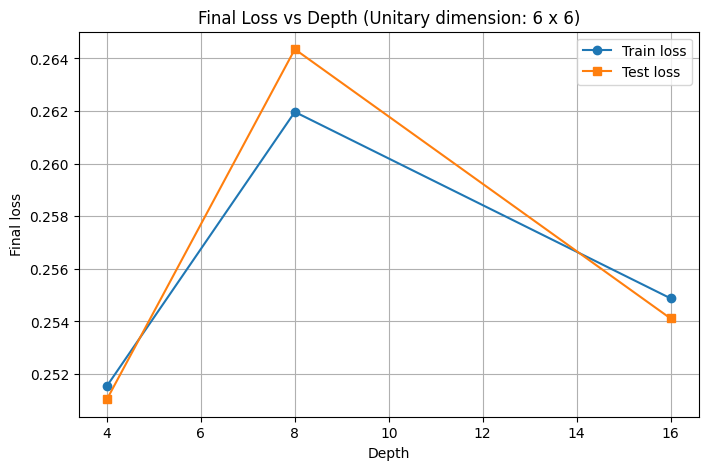

In [66]:
# Plot final losses vs depth 
depth = [r["depth"] for r in results]
train_loss = [r["train_loss_after"] for r in results]
test_loss = [r["test_loss_after"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(depth, train_loss, 'o-', label="Train loss")
plt.plot(depth, test_loss, 's-', label="Test loss")
plt.xlabel("Depth")
plt.ylabel("Final loss")
plt.title(f"Final Loss vs Depth (Unitary dimension: 6 x 6)")
plt.legend()
plt.grid(True)
plt.show()

In [67]:
# Varying the number of features

feature_dims = list(range(3, 11))  # 3d to 10d
depth = 32                         # Set your desired constant depth here
num_steps = 1000
step_size = 1e-2

results = []
plt.figure(figsize=(10, 6))

for f_dims in feature_dims:
    print(f"Training with {f_dims} features (depth={depth})")
    a =time.time()
    file_path_train = fr"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_{f_dims}d_train.csv"
    file_path_test  = fr"C:\Users\kl23874\.spyder-py3\mnist_pca\mnist_3-5_{f_dims}d_test.csv"
    data_train = pd.read_csv(file_path_train)
    data_train = jnp.array(data_train)
    data_test = pd.read_csv(file_path_test)
    data_test = jnp.array(data_test)
    num_features = data_train.shape[1] - 1

    train_set = data_train[:, :num_features]
    train_set = rescale_data(train_set, min_val=-(np.pi)/2, max_val=(np.pi/2))
    train_labels = data_train[:, num_features]
    test_set = data_test[:, :num_features]
    test_set = rescale_data(test_set, min_val=-(np.pi)/2, max_val=(np.pi/2))
    test_labels = data_test[:, num_features]

    a = time.time()
    init_phases = initialize_phases(depth, 2*num_features)
    weights_data = jnp.ones(shape=[init_phases.shape[0], init_phases.shape[1]])
    init = [
        init_phases, train_set, train_labels, weights_data,
        0.0*init_phases, 0.0*init_phases, 0.0*weights_data, 0.0*weights_data
    ]
    b = time.time()
    carry, loss_mem = jax.block_until_ready(train)(init)
    e = time.time()
    trained_phases = carry[0]
    trained_weights = carry[3]

    train_loss_before = float(loss(init_phases, train_set, train_labels, weights_data))
    train_loss_after = float(loss(trained_phases, train_set, train_labels, trained_weights))
    test_loss_after = float(loss(trained_phases, test_set, test_labels, trained_weights))
    train_time_min = (e-b)/60

    plt.plot(np.array(loss_mem[:,0]), np.array(loss_mem[:,1]), label=f"({2*f_dims} x {2*f_dims})")


    d = time.time()
    total_time_min = (d-a)/60
    results.append({
        "features": f_dims,
        "train_loss_before": train_loss_before,
        "train_loss_after": train_loss_after,
        "test_loss_after": test_loss_after,
        "train_time_min": train_time_min,
        "total_time_min": total_time_min
    })

plt.xlim(0, num_steps)
plt.xlabel("step")
plt.ylabel("loss")
plt.title(f"Learning Curves for Different Feature Dimensions (Depth={depth}) - Multiphoton input")

plt.legend(title="Unitary dimension")
plt.show()

# Create and print the results table
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format="%.4F"))

Training with 3 features (depth=32)


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\kl23874\\.spyder-py3\\mnist_pca\\mnist_3-5_3d_train.csv'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot final losses vs feature size
features = [r["features"] for r in results]
train_loss = [r["train_loss_after"] for r in results]
test_loss = [r["test_loss_after"] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(features, train_loss, 'o-', label="Train loss")
plt.plot(features, test_loss, 's-', label="Test loss")
plt.xlabel("Feature size (d)")
plt.ylabel("Final loss")
plt.title(f"Final Loss vs Feature Size (Depth={depth})")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#check multiphoton output combinations

# Example usage of the measurement function
n = 3  # number of matrices
size = 6  # size of each identity matrix

# Create a (n, 1, 1) array of factors: [0], [1], [2]
factors = jnp.arange(n, dtype=jnp.complex64).reshape(-1, 1, 1)
# Create a (1, 6, 6) identity matrix and broadcast
ones_matrix = jnp.arange(n * size * size, dtype=jnp.complex64).reshape(n, size, size)
# Multiply to get (n, 6, 6)
temp_unitaries = factors * ones_matrix

#print(temp_unitaries.shape)  # (3, 6, 6)
#print(temp_unitaries)

result_measurement, combos1, probs1, _ = measurement(temp_unitaries, num_photons = 3)
#print(probs1)
#print(result_measurement.shape)  # Should be (num_samples, 2, 6) if num_samples is the batch size
parity = jnp.sum(combos1, axis=1) % 2
mask = (parity == 1)  # shape (n_combos,)

arr = jnp.arange(1, 21)
test = parity*arr
test1 = mask*arr
print("Masked array:", test1)
print("Even indices:", test)
print(parity)  # 0 = even, 1 = odd
print(combos1)



In [ ]:
#check permanent calculation

def perm_3x3_jax(mat):
    # Only works for 3x3 matrices
    perms = jnp.array([
        [0, 1, 2],
        [0, 2, 1],
        [1, 0, 2],
        [1, 2, 0],
        [2, 0, 1],
        [2, 1, 0]
    ])
    return jnp.sum(jnp.prod(mat[jnp.arange(3), perms], axis=1))

# Example usage
mat = jnp.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=jnp.complex64)
result_perm = perm_3x3_jax(mat) 
print("Permanent of the matrix:", result_perm)  # Should print the permanent of the matrix
mat1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]], dtype=jnp.complex64)
print("Permanent of the matrix (using numpy):", perm(mat1))  # For comparison with numpy's perm function